# Inception

## 1. Import libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive') 

import sys,os
import fnmatch
sys.path.insert(0,'/content/drive/My Drive/5242_final_project')

Mounted at /content/drive


In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Sampler
from torchvision import transforms
import torch
import random
import pandas as pd
from collections import defaultdict 
from types import SimpleNamespace

## 2. Load our dataset structure

In [ ]:
class ImageDataset(Dataset):

    def __init__(self, img_dir, fruit_category, image_size = 255, class_size = 5000, transform = False):
        self.img_dir = img_dir
        self.transform = transform
        self.fruit_category = fruit_category
        self.class_size = class_size
        self.data_dict = dict(np.load(img_dir))
        self.image_size = image_size
        
        self.transform_img = transforms.Compose([transforms.ToPILImage(),
                                                transforms.Resize(image_size),
                                                transforms.ToTensor()])
        self.transform_label = transforms.Compose([transforms.ToTensor()])
        
    def __len__(self):
        return self.class_size * len(self.fruit_category)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        class_index = int(idx // self.class_size)
        category =  self.fruit_category[class_index]
        category_idx = int(idx % self.class_size)
        
        label = np.zeros((len(self.fruit_category), 1))
        label[class_index] = 1
        
        image_ary =  self.data_dict[category][category_idx]
        
        sample = {'image': image_ary, 'label': label}
        if self.transform:
            sample['image'] = self.transform_img(sample['image'])
            sample['label'] = self.transform_label(sample['label'])
        return sample 

## 3. Build CNN model structure

In [ ]:
act_fn_by_name = {
    "tanh": nn.Tanh,
    "relu": nn.ReLU,
    "leakyrelu": nn.LeakyReLU,
    "gelu": nn.GELU
}

In [ ]:
class InceptionBlock(nn.Module):

    def __init__(self, c_in, c_red : dict, c_out : dict, act_fn):
        """
        Inputs:
            c_in - Number of input feature maps from the previous layers
            c_red - Dictionary with keys "3x3" and "5x5" specifying the output of the dimensionality reducing 1x1 convolutions
            c_out - Dictionary with keys "1x1", "3x3", "5x5", and "max"
            act_fn - Activation class constructor (e.g. nn.ReLU)
        """
        super().__init__()

        self.conv_1x1 = nn.Sequential(
            nn.Conv2d(c_in, c_out["1x1"], kernel_size=1),
            nn.BatchNorm2d(c_out["1x1"]),
            act_fn()
        )

        self.conv_3x3 = nn.Sequential(
            nn.Conv2d(c_in, c_red["3x3"], kernel_size=1),
            nn.BatchNorm2d(c_red["3x3"]),
            act_fn(),
            nn.Conv2d(c_red["3x3"], c_out["3x3"], kernel_size=3, padding=1),
            nn.BatchNorm2d(c_out["3x3"]),
            act_fn()
        )

        self.conv_5x5 = nn.Sequential(
            nn.Conv2d(c_in, c_red["5x5"], kernel_size=1),
            nn.BatchNorm2d(c_red["5x5"]),
            act_fn(),
            nn.Conv2d(c_red["5x5"], c_out["5x5"], kernel_size=5, padding=2),
            nn.BatchNorm2d(c_out["5x5"]),
            act_fn()
        )

        self.max_pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, padding=1, stride=1),
            nn.Conv2d(c_in, c_out["max"], kernel_size=1),
            nn.BatchNorm2d(c_out["max"]),
            act_fn()
        )

    def forward(self, x):
        x_1x1 = self.conv_1x1(x)
        x_3x3 = self.conv_3x3(x)
        x_5x5 = self.conv_5x5(x)
        x_max = self.max_pool(x)
        x_out = torch.cat([x_1x1, x_3x3, x_5x5, x_max], dim=1)
        return x_out

class Inception(nn.Module):

    def __init__(self, num_classes=7, act_fn_name="relu", **kwargs):
        super().__init__()
        self.hparams = SimpleNamespace(num_classes=num_classes,
                                       act_fn_name=act_fn_name,
                                       act_fn=act_fn_by_name[act_fn_name])
        self._create_network()
        self._init_params()

    def _create_network(self):
        self.input_net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            self.hparams.act_fn()
        )
        self.inception_blocks = nn.Sequential(
            InceptionBlock(64, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 16, "3x3": 32, "5x5": 8, "max": 8}, act_fn=self.hparams.act_fn),
            InceptionBlock(64, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 24, "3x3": 48, "5x5": 12, "max": 12}, act_fn=self.hparams.act_fn),
            nn.MaxPool2d(3, stride=2, padding=1), 
            InceptionBlock(96, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 24, "3x3": 48, "5x5": 12, "max": 12}, act_fn=self.hparams.act_fn),
            InceptionBlock(96, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 16, "3x3": 48, "5x5": 16, "max": 16}, act_fn=self.hparams.act_fn),
            InceptionBlock(96, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 16, "3x3": 48, "5x5": 16, "max": 16}, act_fn=self.hparams.act_fn),
            InceptionBlock(96, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 32, "3x3": 48, "5x5": 24, "max": 24}, act_fn=self.hparams.act_fn),
            nn.MaxPool2d(3, stride=2, padding=1), 
            InceptionBlock(128, c_red={"3x3": 48, "5x5": 16}, c_out={"1x1": 32, "3x3": 64, "5x5": 16, "max": 16}, act_fn=self.hparams.act_fn),
            InceptionBlock(128, c_red={"3x3": 48, "5x5": 16}, c_out={"1x1": 32, "3x3": 64, "5x5": 16, "max": 16}, act_fn=self.hparams.act_fn)
        )
        self.output_net = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(128, self.hparams.num_classes)
        )

    def _init_params(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(
                    m.weight, nonlinearity=self.hparams.act_fn_name)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.input_net(x)
        x = self.inception_blocks(x)
        x = self.output_net(x)
        return x

##  4. Load train and validation data

In [ ]:
# quickdraw
QURIES = ['pineapple', 'apple', 'banana', 'strawberry', 'pear', 'watermelon', 'grapes']  

train_quickdraw_dir = sys.path[0]+'/compressed_quickdraw_train.npz'
train_quickdraw = ImageDataset(train_quickdraw_dir, QURIES, image_size = 32, class_size = 4000)
trainloader = DataLoader(train_quickdraw, batch_size=128, shuffle=True, pin_memory=True, num_workers=32)
test_quickdraw_dir = sys.path[0]+'/compressed_quickdraw_test.npz'
test_quickdraw = ImageDataset(test_quickdraw_dir, QURIES, image_size = 32, class_size = 1000)
testloader = DataLoader(test_quickdraw, batch_size=128, shuffle=True, pin_memory=True, num_workers=32)

In [ ]:
# realworld
QURIES = ['pineapple', 'apple', 'banana', 'strawberry', 'pear', 'watermelon', 'grapes']  

train_realworld_dir = sys.path[0]+'/compressed_realworld_train.npz'
train_realworld = ImageDataset(train_realworld_dir, QURIES, image_size = 32, class_size = 4000)
trainloader = DataLoader(train_realworld, batch_size=128, shuffle=True, pin_memory=True, num_workers=32)
test_realworld_dir = sys.path[0]+'/compressed_realworld_test.npz'
test_realworld = ImageDataset(test_realworld_dir, QURIES, image_size = 32, class_size = 1000)
testloader = DataLoader(test_realworld, batch_size=128, shuffle=True, pin_memory=True, num_workers=32)

## 5. Training settings

In [ ]:
num_epoch = 20
batch_size = 128
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model =Inception().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)

## 6. Train and Test Procedure 

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    train_loss, correct = 0, 0
    for _, data in enumerate(dataloader):
        X, y = data['image'].to(device), data['label'].to(device)
        y = y.squeeze()
        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss += loss.item()
        correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (_ % 100 == 0):
            loss, current = loss.item(), _ * len(X)
            print(f"Loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    train_loss /= num_batches
    correct /= size
    return correct, train_loss

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
         for _, data in enumerate(dataloader):
            X, y = data['image'].to(device), data['label'].to(device)
            y = y.squeeze()
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print("------------ Test -----------")
    print(f"Accuracy: {(100*correct):>2f}%, Avg loss: {test_loss:>8f} \n")
    return correct, test_loss

In [ ]:
# Quickdraw
train_quickdraw_acc = []
train_quickdraw_loss = []
val_quickdraw_acc = []
val_quickdraw_loss = []

for epoch in range(num_epoch):
  train_acc, train_loss = train(trainloader, model, criterion, optimizer)
  val_acc, val_loss = test(testloader, model, criterion)
  train_quickdraw_acc.append(train_acc)
  train_quickdraw_loss.append(train_loss)
  val_quickdraw_acc.append(val_acc)
  val_quickdraw_loss.append(val_loss)

Loss: 1.979322  [    0/28000]
Loss: 1.547291  [12800/28000]
Loss: 1.185307  [25600/28000]
------------ Test -----------
Accuracy: 75.042857%, Avg loss: 1.116914 

Loss: 1.083005  [    0/28000]
Loss: 0.887716  [12800/28000]
Loss: 0.714453  [25600/28000]
------------ Test -----------
Accuracy: 83.928571%, Avg loss: 0.708867 

Loss: 0.803748  [    0/28000]
Loss: 0.618932  [12800/28000]
Loss: 0.492610  [25600/28000]
------------ Test -----------
Accuracy: 87.128571%, Avg loss: 0.519817 

Loss: 0.429238  [    0/28000]
Loss: 0.515026  [12800/28000]
Loss: 0.496616  [25600/28000]
------------ Test -----------
Accuracy: 89.028571%, Avg loss: 0.420971 

Loss: 0.405140  [    0/28000]
Loss: 0.386883  [12800/28000]
Loss: 0.413283  [25600/28000]
------------ Test -----------
Accuracy: 89.671429%, Avg loss: 0.375614 

Loss: 0.343990  [    0/28000]
Loss: 0.364815  [12800/28000]
Loss: 0.289328  [25600/28000]
------------ Test -----------
Accuracy: 90.557143%, Avg loss: 0.335429 

Loss: 0.297787  [    0

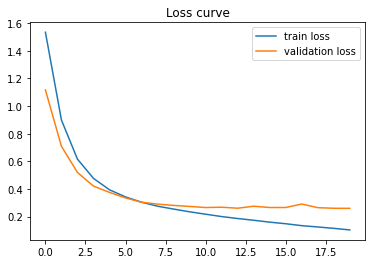

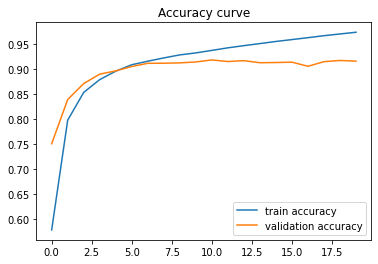

In [ ]:
epoches = [i for i in range(num_epoch)]
plt.plot(epoches, train_quickdraw_loss, label="train loss")
plt.plot(epoches, val_quickdraw_loss, label="validation loss")
plt.legend()
plt.title('Loss curve')
plt.show()

plt.plot(epoches, train_quickdraw_acc, label="train accuracy")
plt.plot(epoches, val_quickdraw_acc, label="validation accuracy")
plt.legend()
plt.title('Accuracy curve')
plt.show()

In [ ]:
torch.save(model, sys.path[0]+'/Inception_quickdraw_model.pth')

In [ ]:
print(train_quickdraw_loss)

[1.5341553701034853, 0.8991504127140755, 0.6161282341109714, 0.47699825083556424, 0.39429769081016514, 0.342790764695937, 0.3046886844355474, 0.275614949978163, 0.2548685404854201, 0.23515681957760742, 0.21777627853050097, 0.2005769810487475, 0.1864624847302885, 0.17391851614305923, 0.16021759980805467, 0.14871927477718455, 0.13485123915048294, 0.1253989653228334, 0.11535915978586307, 0.10402632573151284]


In [ ]:
print(train_quickdraw_acc)

[0.5774642857142858, 0.7978214285714286, 0.8535714285714285, 0.8792857142857143, 0.8961785714285714, 0.9091428571428571, 0.9161785714285714, 0.9227857142857143, 0.9288571428571428, 0.9328928571428572, 0.9378928571428572, 0.9430714285714286, 0.9474285714285714, 0.9516071428571429, 0.9558571428571428, 0.9596428571428571, 0.9634642857142857, 0.9674285714285714, 0.9708928571428571, 0.9743571428571428]


In [ ]:
print(val_quickdraw_loss)

[1.1169138015656779, 0.7088665072475935, 0.5198165999960336, 0.42097089594759635, 0.37561413838630414, 0.33542910780692753, 0.304507122941696, 0.2906581053260156, 0.28137361281785145, 0.27379942739634805, 0.26596620480168287, 0.26829153565245706, 0.261016144863044, 0.275557360940116, 0.2660701189871456, 0.2662144422216034, 0.2911865461549321, 0.26502964076999286, 0.26065498565154915, 0.26004530126695213]


In [ ]:
print(val_quickdraw_acc)

[0.7504285714285714, 0.8392857142857143, 0.8712857142857143, 0.8902857142857142, 0.8967142857142857, 0.9055714285714286, 0.912, 0.9121428571428571, 0.9128571428571428, 0.9147142857142857, 0.9187142857142857, 0.9155714285714286, 0.9172857142857143, 0.9131428571428571, 0.9135714285714286, 0.9142857142857143, 0.906, 0.9152857142857143, 0.9177142857142857, 0.9162857142857143]


In [ ]:
# Realworld
train_realworld_acc = []
train_realworld_loss = []
val_realworld_acc = []
val_realworld_loss = []

for epoch in range(num_epoch):
  train_acc, train_loss = train(trainloader, model, criterion, optimizer)
  val_acc, val_loss = test(testloader, model, criterion)
  train_realworld_acc.append(train_acc)
  train_realworld_loss.append(train_loss)
  val_realworld_acc.append(val_acc)
  val_realworld_loss.append(val_loss)

Loss: 1.970704  [    0/28000]
Loss: 1.647705  [12800/28000]
Loss: 1.400706  [25600/28000]
------------ Test -----------
Accuracy: 59.328571%, Avg loss: 1.303658 

Loss: 1.334938  [    0/28000]
Loss: 1.237809  [12800/28000]
Loss: 1.121643  [25600/28000]
------------ Test -----------
Accuracy: 72.057143%, Avg loss: 0.969772 

Loss: 1.013706  [    0/28000]
Loss: 1.097416  [12800/28000]
Loss: 0.930965  [25600/28000]
------------ Test -----------
Accuracy: 78.171429%, Avg loss: 0.729772 

Loss: 0.944873  [    0/28000]
Loss: 0.714589  [12800/28000]
Loss: 0.737952  [25600/28000]
------------ Test -----------
Accuracy: 82.242857%, Avg loss: 0.595010 

Loss: 0.734391  [    0/28000]
Loss: 0.737961  [12800/28000]
Loss: 0.770071  [25600/28000]
------------ Test -----------
Accuracy: 84.828571%, Avg loss: 0.504776 

Loss: 0.617632  [    0/28000]
Loss: 0.480892  [12800/28000]
Loss: 0.584650  [25600/28000]
------------ Test -----------
Accuracy: 86.414286%, Avg loss: 0.447319 

Loss: 0.500188  [    0

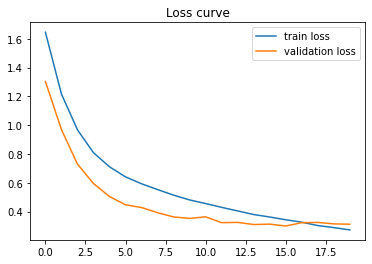

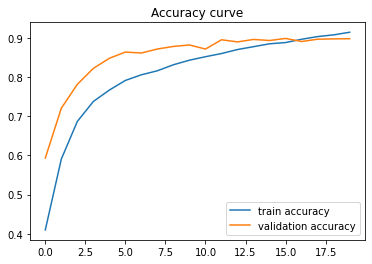

In [ ]:
epoches = [i for i in range(num_epoch)]
plt.plot(epoches, train_realworld_loss, label="train loss")
plt.plot(epoches, val_realworld_loss, label="validation loss")
plt.legend()
plt.title('Loss curve')
plt.show()

plt.plot(epoches, train_realworld_acc, label="train accuracy")
plt.plot(epoches, val_realworld_acc, label="validation accuracy")
plt.legend()
plt.title('Accuracy curve')
plt.show()

In [ ]:
torch.save(model, sys.path[0]+'/Inception_realworld_model.pth')

In [ ]:
print(train_realworld_acc)

[0.4095714285714286, 0.5905714285714285, 0.6868928571428572, 0.7378571428571429, 0.7670714285714286, 0.7916428571428571, 0.8060714285714285, 0.8163928571428571, 0.83175, 0.8433928571428572, 0.8522857142857143, 0.8603928571428572, 0.8706428571428572, 0.8779285714285714, 0.8852857142857142, 0.8884642857142857, 0.8968571428571429, 0.90375, 0.9081071428571429, 0.9148214285714286]


In [ ]:
print(train_realworld_loss)

[1.6454635966189817, 1.2163931017951446, 0.967913655210779, 0.8089210012738869, 0.7111143976549011, 0.6409570967089142, 0.5931795318554202, 0.5529410019621149, 0.5143736986473927, 0.4809634260624383, 0.45585057986638916, 0.42951189705834625, 0.40456406201296524, 0.3795610558917946, 0.36244394095912114, 0.34327948681952797, 0.3264049841858711, 0.30315306713385415, 0.28889049638441633, 0.27277808645452173]


In [ ]:
print(val_realworld_acc)

[0.5932857142857143, 0.7205714285714285, 0.7817142857142857, 0.8224285714285714, 0.8482857142857143, 0.8641428571428571, 0.8617142857142858, 0.872, 0.8785714285714286, 0.8822857142857143, 0.8718571428571429, 0.8955714285714286, 0.8901428571428571, 0.8964285714285715, 0.8937142857142857, 0.899, 0.8911428571428571, 0.897, 0.8978571428571429, 0.8982857142857142]


In [ ]:
print(val_realworld_loss)

[1.30365810985523, 0.9697722407937731, 0.7297720592458034, 0.5950095413817651, 0.5047763118452264, 0.44731906879571537, 0.428245714193936, 0.39248430619333685, 0.3629245297795181, 0.35259217578444585, 0.36368036080690097, 0.3231659903375216, 0.3250449756713432, 0.31006041729993394, 0.31298390893431977, 0.29998508612996755, 0.32288051655868427, 0.32482717642685255, 0.31472025947657395, 0.3122758886785645]


## 7. Search Engine Accuracy

In [ ]:
QURIES = ['pineapple', 'apple', 'banana', 'strawberry', 'pear', 'watermelon', 'grapes']  
test_quickdraw_dir = sys.path[0]+'/compressed_quickdraw_test.npz'
test_quickdraw = ImageDataset(test_quickdraw_dir, QURIES, image_size = 32, class_size = 1000)
quickdraw_testloader = DataLoader(test_quickdraw, batch_size=128, shuffle=True, pin_memory=True, num_workers=32)
 
test_realworld_dir = sys.path[0]+'/compressed_realworld_test.npz'
test_realworld = ImageDataset(test_realworld_dir, QURIES, image_size = 32, class_size = 1000)
realworld_testloader = DataLoader(test_realworld, batch_size=128, shuffle=True, pin_memory=True, num_workers=32)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
quickdraw_model=torch.load(sys.path[0]+'/Inception_quickdraw_model.pth')
quickdraw_model.eval()

Inception(
  (input_net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (inception_blocks): Sequential(
    (0): InceptionBlock(
      (conv_1x1): Sequential(
        (0): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv_3x3): Sequential(
        (0): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
      )
      (conv_5x5): Sequential(
        (0): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
       

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
realworld_model=torch.load(sys.path[0]+'/Inception_realworld_model.pth')
realworld_model.eval()

Inception(
  (input_net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (inception_blocks): Sequential(
    (0): InceptionBlock(
      (conv_1x1): Sequential(
        (0): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv_3x3): Sequential(
        (0): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
      )
      (conv_5x5): Sequential(
        (0): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
       

In [ ]:
from collections import defaultdict 
features = defaultdict(list)

correct = 0
total = 0
with torch.no_grad():
    for data in quickdraw_testloader:
        data['label'] = torch.argmax(data['label'].squeeze(),dim = 1)
        images, labels = data['image'].to(device), data['label'].to(device)
        outputs = quickdraw_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        labels_sq = labels.tolist()
        for i in range(outputs.shape[0]):
              features[labels_sq[i]].append(outputs[i])

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 91 %


In [ ]:
from collections import defaultdict 
features_real = defaultdict(list)

correct = 0
total = 0
with torch.no_grad():
    for data in realworld_testloader:
        data['label'] = torch.argmax(data['label'].squeeze(),dim = 1)
        images, labels = data['image'].to(device), data['label'].to(device)
        outputs = realworld_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        labels_sq = labels.tolist()
        for i in range(outputs.shape[0]):
              features_real[labels_sq[i]].append(outputs[i])

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 89 %


In [ ]:
fea1 = torch.empty((7000,7))
for i in range(len(features)):
  fea1[i*1000:1000*(i+1)] = torch.stack(features[i])

fea2 = torch.empty((7000,7))
for i in range(len(features_real)):
  fea2[i*1000:1000*(i+1)] = torch.stack(features_real[i])

In [ ]:
def cos_similarity(k,fea2,fea1):
  correct = 0
  total = 0
  real_matrix = F.normalize(fea2) 
  for idx, image in enumerate(fea1):
    feature1 = image.reshape(1,-1)
    a = F.normalize(feature1)
    res = F.cosine_similarity(a,real_matrix)
    _,predict = res.topk(k, largest=True, sorted=True)

    correct += sum([idx//1000==i//1000 for i in predict]).item()
    total += k

  print(f"Top {k}: accuracy {(correct/total):.3f}")  

In [ ]:
for k_choice in [1,3,5,10,20]:
  cos_similarity(k_choice,fea2,fea1)

Top 1: accuracy 0.812
Top 3: accuracy 0.852
Top 5: accuracy 0.863
Top 10: accuracy 0.873
Top 20: accuracy 0.881


In [ ]:
epoches = [i for i in range(num_epoch)]
train_quickdraw_loss = [1.5341553701034853, 0.8991504127140755, 0.6161282341109714, 0.47699825083556424, 0.39429769081016514, 0.342790764695937, 0.3046886844355474, 0.275614949978163, 0.2548685404854201, 0.23515681957760742, 0.21777627853050097, 0.2005769810487475, 0.1864624847302885, 0.17391851614305923, 0.16021759980805467, 0.14871927477718455, 0.13485123915048294, 0.1253989653228334, 0.11535915978586307, 0.10402632573151284]
train_quickdraw_acc = [0.5774642857142858, 0.7978214285714286, 0.8535714285714285, 0.8792857142857143, 0.8961785714285714, 0.9091428571428571, 0.9161785714285714, 0.9227857142857143, 0.9288571428571428, 0.9328928571428572, 0.9378928571428572, 0.9430714285714286, 0.9474285714285714, 0.9516071428571429, 0.9558571428571428, 0.9596428571428571, 0.9634642857142857, 0.9674285714285714, 0.9708928571428571, 0.9743571428571428]
val_quickdraw_loss = [1.1169138015656779, 0.7088665072475935, 0.5198165999960336, 0.42097089594759635, 0.37561413838630414, 0.33542910780692753, 0.304507122941696, 0.2906581053260156, 0.28137361281785145, 0.27379942739634805, 0.26596620480168287, 0.26829153565245706, 0.261016144863044, 0.275557360940116, 0.2660701189871456, 0.2662144422216034, 0.2911865461549321, 0.26502964076999286, 0.26065498565154915, 0.26004530126695213]
val_quickdraw_acc = [0.7504285714285714, 0.8392857142857143, 0.8712857142857143, 0.8902857142857142, 0.8967142857142857, 0.9055714285714286, 0.912, 0.9121428571428571, 0.9128571428571428, 0.9147142857142857, 0.9187142857142857, 0.9155714285714286, 0.9172857142857143, 0.9131428571428571, 0.9135714285714286, 0.9142857142857143, 0.906, 0.9152857142857143, 0.9177142857142857, 0.9162857142857143]
train_realworld_loss = [1.6454635966189817, 1.2163931017951446, 0.967913655210779, 0.8089210012738869, 0.7111143976549011, 0.6409570967089142, 0.5931795318554202, 0.5529410019621149, 0.5143736986473927, 0.4809634260624383, 0.45585057986638916, 0.42951189705834625, 0.40456406201296524, 0.3795610558917946, 0.36244394095912114, 0.34327948681952797, 0.3264049841858711, 0.30315306713385415, 0.28889049638441633, 0.27277808645452173]
train_realworld_acc = [0.4095714285714286, 0.5905714285714285, 0.6868928571428572, 0.7378571428571429, 0.7670714285714286, 0.7916428571428571, 0.8060714285714285, 0.8163928571428571, 0.83175, 0.8433928571428572, 0.8522857142857143, 0.8603928571428572, 0.8706428571428572, 0.8779285714285714, 0.8852857142857142, 0.8884642857142857, 0.8968571428571429, 0.90375, 0.9081071428571429, 0.9148214285714286]
val_realworld_loss = [1.30365810985523, 0.9697722407937731, 0.7297720592458034, 0.5950095413817651, 0.5047763118452264, 0.44731906879571537, 0.428245714193936, 0.39248430619333685, 0.3629245297795181, 0.35259217578444585, 0.36368036080690097, 0.3231659903375216, 0.3250449756713432, 0.31006041729993394, 0.31298390893431977, 0.29998508612996755, 0.32288051655868427, 0.32482717642685255, 0.31472025947657395, 0.3122758886785645]
val_realworld_acc = [0.5932857142857143, 0.7205714285714285, 0.7817142857142857, 0.8224285714285714, 0.8482857142857143, 0.8641428571428571, 0.8617142857142858, 0.872, 0.8785714285714286, 0.8822857142857143, 0.8718571428571429, 0.8955714285714286, 0.8901428571428571, 0.8964285714285715, 0.8937142857142857, 0.899, 0.8911428571428571, 0.897, 0.8978571428571429, 0.8982857142857142]

In [ ]:
import pickle

model_history = {
    "epoch": epoches,
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],

    "train_realworld_acc": train_realworld_acc,
    "train_quickdraw_acc": train_quickdraw_acc,
    "val_realworld_acc": val_realworld_acc,
    "val_quickdraw_acc": val_quickdraw_acc,
    "train_realworld_loss": train_realworld_loss,
    "train_quickdraw_loss": train_quickdraw_loss,
    "val_realworld_loss": val_realworld_loss,
    "val_quickdraw_loss": val_quickdraw_loss,
    "k_choice": [1,3,5,10,20], # [1,3,5,10,20]
    "topk_acc": [0.812,0.852,0.863,0.873,0.881]
}

def save_model_history(metrics, filepath):
    with open(filepath, 'wb') as file:
        pickle.dump(metrics, file)

def load_model_history(filepath):
    with open(filepath, 'rb') as file:
        metrics = pickle.load(file)
    return metrics

save_model_history(model_history, sys.path[0]+'/Inception_data.pkl')

In [ ]:
model_history = load_model_history(sys.path[0]+'/Inception_data.pkl')
print(model_history)

{'epoch': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], 'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'train_realworld_acc': [0.4095714285714286, 0.5905714285714285, 0.6868928571428572, 0.7378571428571429, 0.7670714285714286, 0.7916428571428571, 0.8060714285714285, 0.8163928571428571, 0.83175, 0.8433928571428572, 0.8522857142857143, 0.8603928571428572, 0.8706428571428572, 0.8779285714285714, 0.8852857142857142, 0.8884642857142857, 0.8968571428571429, 0.90375, 0.9081071428571429, 0.9148214285714286], 'train_quickdraw_acc': [0.5774642857142858, 0.7978214285714286, 0.8535714285714285, 0.8792857142857143, 0.8961785714285714, 0.9091428571428571, 0.9161785714285714, 0.9227857142857143, 0.9288571428571428, 0.9328928571428572, 0.9378928571428572, 0.9430714285714286, 0.9474285714285714, 0.9516071428571429, 0.9558571428571428, 0.9596428571428571, 0.9634642857142857, 0.9674285714285714, 0.9708928571428571, 0.9743571428571428], 'val_realworld_acc': [0.